#e4_get_X_y_sub.ipynb
Loads the dataset from local zip files and converts the data into numpy arrays of X (data), y(labels), and sub (subject numbers)
>X = (samples, time steps per sample, accel_x/y/z/total_accel)  
>y = {'Undefined','Upstairs','Downstairs','Walking','Jogging','Sitting','Standing'} # activity classification  
>s = 1 # subject number - there is only one subject in this proof-of-concept

y and s are column vectors with number of rows equal to samples.

This is an intermediate representation that can be used to build the train/validate/test arrays.

This is a more function based version than some of the earlier load data code.
One reason is that since the current data set is single subject the sliding
window must be applied after separation into train/val/test groups.

This video describes the code https://mediaflo.txstate.edu/Watch/e4_data_processing. (updates have been made since this was made)


Acknowledgement to and a good example of the WISDM format being pre-processed is https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0  by Nils Ackermann.  


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* Time is off by 6 hrs due to time zone issues - adjusted in Excel/csv but would be good to show it in the correct time zone.
* Change to a callable function broke shapes, not sure why.
* Also, passing a list as a parameter syntax is off - default is empty for now.

In [ ]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import time
import pandas as pd
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime

In [ ]:
#Helper functions especially useful in colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    if 'google.colab' in str(get_ipython()):
        my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
        my_name += ".ipynb"
    else:
        # seems a bit complicated to get filename in any environment
        # and hard coding the name here will make this not portable
        # this should elminate the failure in non-colab instances though
        my_name = 'Executing local file, not running in CoLab'
    return my_name
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    shapes += "shapes call broke during refactor to function"
    return shapes
    for i in np_arr_list:
        print('i=',i)
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

In [ ]:
def unzip_e4_file(zip_ffname, working_dir):
    """checks for local copy, if none unzips the e4 zipfile in working_dir
    Note:  the files themselves do not contain subject info and there are
    multiple files e.g. ACC.csv, BVP,csv etc, in each zipfile.
    It is very important to further process the files using _info.csv method
    :param zip_ffname: the path and filename of the zip file
    :param working_dir: local (colab) directory where csv files will be placed
    :return: nothing"""
    if (os.path.isdir(working_dir)):
        print("Skipping Unzip - Found existing archive in colab at", working_dir)
        return
    else:
        #print("Using source file", zip_ffname)
        print("Unzipping e4 file in local directory", working_dir)
        if (os.path.exists(zip_ffname)):
            shutil.unpack_archive(zip_ffname,working_dir,'zip')
        else:
            print("Error: ", zip_ffname, " not found, exiting")
            return

In [ ]:
def df_from_e4_csv (ffname,col_labels):
    """"reads e4 csv file, uses start time and sample rate to create time indexed
    pandas dataframe.  Note only tested with ACC files, e4 csv files do not
    have header info, this will need to be added based on file type.
    :param ffname:  full filename e.g./content/temp/ACC.csv
    :col_labels: list of colums in csv - varies by type ['accel_x','accel_y...]
    :returns df: time indexed dataframe"""

    df = pd.read_csv(ffname, header=None)
    #start_time = pd.to_datetime(df.iloc[0,0]). #pain to convert too early
    #time.time() supports number of seconds which is what this is
    start_time = df.iloc[0,0] # first line in e4 csv
    sample_freq = df.iloc[1,0] # second line in e4 csv
    df = df.drop(df.index[[0,1]]) # drop 1st two rows, index is now off by 2
    print(ffname, "Sample frequency = ", sample_freq, " Hz")
    #show time in day month format, assumes same timezone
    print("File start time = ", strftime("%a, %d %b %Y %H:%M:%S", localtime(start_time)))  
    # Make the index datetime first so code can be used for other data types
    # Having the index as datetime is required for pandas resampling
    # The start_time pulled from the e4 csv file is a float64 which represents the
    # number of seconds since January 1, 1970, 00:00:00 (UTC)
    # UTC_time is computed for each row, then made into required datetime format
    # that pandas will accept as an index
    df['UTC_time'] = (df.index-2)/sample_freq + start_time
    end_time = df['UTC_time'].iloc[-1]
    print("File end time   = ",strftime("%a, %d %b %Y %H:%M:%S", localtime(end_time)))
    df['datetime'] = pd.to_datetime(df['UTC_time'], unit='s')
    df.set_index('datetime',inplace=True)
    df = df.drop('UTC_time', axis=1)
    df.columns = col_labels
    return df

In [ ]:
def process_e4_accel(df):
    """converts component accel into g and adds accel_ttl column
    per info.txt range is [-2g, 2g] and unit in this file is 1/64g.
    """
    df['accel_x'] = df['accel_x']/64
    df['accel_y'] = df['accel_y']/64
    df['accel_z'] = df['accel_z']/64
    df_sqd = df.pow(2)[['accel_x', 'accel_y', 'accel_z']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    return df

In [ ]:
def show_tag_time(tag_ffname):
    """utility prints time marks from tags.csv to help with video sync 
    and labeling.   When this is run in colab it seems to be GMT regardless
    of timezone settings."
    :param tag_ffname: file to be processed e.g. /content/temp/tags.csv'
    :return: nothing"""
    df_temp = pd.read_csv(tag_ffname, header=None)
    df_temp.columns = ['UTC_time']
    print ("    UTC_time          Local Time")
    for index, row in df_temp.iterrows():
        print(index, row['UTC_time'],
            strftime("%a, %d %b %Y %H:%M:%S", localtime(row['UTC_time'])))
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# link to string formats for date and time

In [ ]:
def label_df_from_csv (df, labels_ffname):
    """adds activity label and subject number to the dataframe based on the
    contents of a .csv file containing time and label info.
    Example csv format (see e4_time_sync.xlsx to help build csv from video)
        start,finish,label,sub
        2019:11:24 18:49:51,2019:11:24 18:50:18,Upstairs,1
        2019:11:24 18:50:18,2019:11:24 18:50:45,Downstairs,1
    :param df : time indexed dataframe from df_from_e4_csv method
    :labels_ffname : csv file with metadata
    :return : a dataframe with label and subject columns added"""
    df_labels = pd.read_csv(labels_ffname)
    df_labels['start'] =  pd.to_datetime(df_labels['start'], format='%Y:%m:%d %H:%M:%S')
    df_labels['finish'] =  pd.to_datetime(df_labels['finish'], format='%Y:%m:%d %H:%M:%S')
    # quick check to make sure all subjects are the same - only 1 sub per csv
    if (not (df_labels['sub'].eq(df_labels['sub'].iloc[0]).all())):
        print('Warning: Multiple subjects detected in csv, unusual for e4 data.')
    df['label']='Undefined' # add column with safe value for labels
    df['sub'] = np.NaN
    for index, row in df_labels.iterrows():
        #print(row['start'], row['finish'],row['label'])
        df.loc[row['start']:row['finish'],'label'] = row['label']
        df.loc[row['start']:row['finish'],'sub'] = row['sub']
    return df
    

In [ ]:
def split_df_to_timeslice_nparrays(df, time_steps, step):
    """slice the df into segments of time_steps length and return X, y, sub
    ndarrays.  This is specific to an e4 ACC.csv file processed into dataframe.
    """
    N_FEATURES = 4 # maybe better to use # columns minus 2 (label and sub)
    # TODO - better yet pass in feature names and use length to set
    # if step = time_steps there is no overlap
    segments = []
    labels = []
    subject = []
    for i in range(0, len(df) - time_steps, step):
        df_segX = df[['accel_x', 'accel_y', 'accel_z','accel_ttl']].iloc[i: i + time_steps]
        df_lbl = df['label'].iloc[i: i + time_steps]
        df_sub = df['sub'].iloc[i: i + time_steps]
        # Save only if labels are the same for the entire segment and valid
        if (df_lbl.value_counts().iloc[0] != time_steps):
            #print('Segment at','contains multiple labels.  Discarding.')
            continue

        if 'Undefined' in df_lbl.values :
            #print('Segment contains Undefined labels.  Discarding')
            continue
        # Save only if sub is the same for the entire segment and valid
        if (df_sub.value_counts().iloc[0] != time_steps):
            print('Segment at','contains multiple subjects.  Discarding.')
            continue
        segments.append(df_segX.to_numpy())
        labels.append(df['label'].iloc[i])
        subject.append(df['sub'].iloc[i])

    # Bring the segments into a better shape, convert to nparrays
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    subject = np.asarray(subject)
    # both labels and sub are row arrays, change to single column arrays
    labels = labels[np.newaxis].T
    subject = subject[np.newaxis].T
    # check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(reshaped_segments))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size==0):
        print("No NaN entries found")
    else:
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    return reshaped_segments, labels, subject

# Main Function to generate ndarrays

In [ ]:
def get_X_y_sub(
    working_dir='/content/temp', # this directory will be created inside colab
    # you probably need to change this path to your google drive mount
    zip_dir = '/content/drive/MyDrive/Colab Notebooks/imics_lab_repositories/load_data_time_series_dev/HAR/e4_wristband_Nov2019/zip_datafiles/sub1',
    zip_flist = [],
    # note the longer walk x25540_ zip file has not been labeled, this is for experiment only
    #zip_flist = ['1574625540_A01F11.zip'] # Old main to Alkek and back
    time_steps = 96,
    step = 32 #if equal to time_steps there will be no overlap of sliding window
    ):
    """processes e4 zip file and associated label csv file into X (data),
     y (labels), and sub (subject number) ndarrays.
     Returns X, y, sub, xys_info (a text file)
    """
    # create blank ndarrays to append to
    my_X = np.zeros(shape=(1,time_steps,4))
    my_y = np.full(shape=(1,1), fill_value='n/a',dtype='<U10') # unicode 10 char
    my_sub = np.zeros(shape=(1,1),dtype=int) # one subject number per entry
    for i in zip_flist:
        zip_ffname = zip_dir + '/' + i
        print('Processing ', i)
        unzip_e4_file(zip_ffname, working_dir)
        # following portion of code is unique to ACC only files
        ffname = working_dir + '/ACC.csv'
        col_labels = ['accel_x', 'accel_y', 'accel_z']
        my_df = df_from_e4_csv(ffname, col_labels)
        my_df = process_e4_accel(my_df)
        #print(my_df.head())
        print('Tag info (button presses) from tags.csv')
        tag_ffname = working_dir + '/tags.csv'
        show_tag_time(tag_ffname)
        # Generate associated csv filename, forces the long numbered filenames to match
        labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
        # print ('label file ', labels_ffname)
        my_df = label_df_from_csv (my_df, labels_ffname)
        my_df['label'].value_counts()
        print ("Label Counts\n",my_df['label'].value_counts())
        temp_X, temp_y, temp_sub = split_df_to_timeslice_nparrays(my_df, time_steps, step)
        print(get_shapes([temp_X, temp_y, temp_sub]))
        #print(temp_X[:5]) # "head" for ndarray
        #print(temp_y[:5])
        #print(temp_sub[:5])
        my_X = np.vstack([my_X, temp_X])
        my_y = np.vstack([my_y, temp_y])
        my_sub = np.vstack([my_sub, temp_sub])
        # next line fails on windows, trying shutil to see if more portable
        #!rm -rf $working_dir # remove csv to start processing next file
        shutil.rmtree(working_dir)

    #delete first row placeholders
    X = np.delete(my_X, (0), axis=0) 
    y = np.delete(my_y, (0), axis=0) 
    sub = np.delete(my_sub, (0), axis=0)
    sub = sub.astype(int) # convert from float to int
    print(get_shapes([X, y, sub]))
    # Print final counts for label ndarray - not quite as easy as pandas df
    unique, counts = np.unique(y, return_counts=True)
    print("Final Label Counts")
    print (np.asarray((unique, counts)).T)

    xys_info = 'e4 November 2019 zip files\n'
    xys_info += ' '.join([str(elem) for elem in zip_flist]) # conv list to string
    xys_info += '\nTime steps =' + str(time_steps) + ', Step =' + str(step) + ', no resample\n'
    xys_info += 'Final Shapes\n'
    xys_info += get_shapes([X, y, sub])
    print (xys_info)
    return X, y, sub, xys_info

In [ ]:
if __name__ == "__main__":
    print("Processing e4 zip files and label csv into X, y, sub ndarrays")
    X, y, sub, xys_info = get_X_y_sub(zip_flist = ['1574621345_A01F11.zip','1574622389_A01F11.zip', '1574624998_A01F11.zip'])
    #X, y, sub, xys_info = get_X_y_sub(zip_flist = ['1574625540_A01F11.zip']) # Old main to Alkek and back
    # note the longer walk x25540_ zip file has not been labeled, all valid segments = 'Not_Labeled'
    print("X shape ",X.shape,"dtype = ",X.dtype)
    print("y shape ",y.shape,"dtype = ",y.dtype)
    print("sub shape ",sub.shape,"dtype = ",sub.dtype)


Processing e4 zip files and label csv into X, y, sub ndarrays
Processing  1574621345_A01F11.zip
Unzipping e4 file in local directory /content/temp
/content/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 18:49:35
1 1574621774.22 Sun, 24 Nov 2019 18:56:14
Label Counts
 Upstairs      6208
Downstairs    5889
Undefined     5405
Name: label, dtype: int64
No NaN entries found
shapes call broke when making the function - not sure why
Processing  1574622389_A01F11.zip
Unzipping e4 file in local directory /content/temp
/content/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 19:06:29
File end time   =  Sun, 24 Nov 2019 19:15:03
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574622432.21 Sun, 24 Nov 2019 19:07:12
1 1574622822.72 Sun, 24 Nov 2019 19:13

#Save arrays to drive

In [ ]:
if False: #change to true to save files interactively
    output_dir = '/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/labeled_as_3_sub'
    #output_dir = '/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/3s_window_2s_overlap'
    #output_dir = '/content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/free_walk_not_labeled'
    if (os.path.isdir(output_dir)):
        #quick check for existing files, '.ipynb_checkpoints' file 
        #makes it more complicated to see if directory is empty
        if (not os.path.isfile(output_dir + '/X.npy')):
            summary = "e4 Nov 2019 data\n"
            summary += "Saved to " + output_dir + "\n"
            summary += "Generated by " + what_is_my_name() 
            summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

            info_fname = output_dir +'/'+'info.txt'
            full_info = summary + "\n" + xys_info + "\n"
            print(full_info)

            with open(info_fname, "w") as file_object:
                file_object.write(full_info)

            if True:
                np.save(output_dir + '/'+'X.npy',X)
                np.save(output_dir + '/'+'y.npy',y)
                np.save(output_dir + '/'+'sub.npy',sub)
        else:
            print("Error "+output_dir+" contains X.npy, please delete files")
    else:
        print(output_dir + " not found, please create directory") 

e4 Nov 2019 data
Saved to /content/drive/MyDrive/Processed_Datasets/e4_Nov2019_xys/labeled_as_3_sub
Generated by e4_get_X_y_sub.ipynb on Jun-25-2021_1647
e4 November 2019 zip files
1574621345_A01F11.zip 1574622389_A01F11.zip 1574624998_A01F11.zip
Time steps =96, Step =32, no resample
Final Shapes
shapes call broke when making the function - not sure why



['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


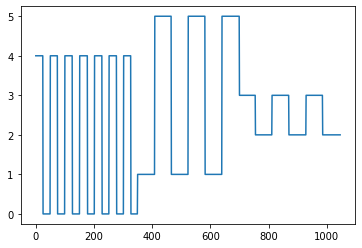

In [ ]:
# Plot y - must convert to numeric first
def plot_activities():
    uniques, y_num = np.unique(y, return_inverse=True)
    print (uniques)
    plt.plot(y_num) 
    plt.show()
#plot_activities()

[11 12 13]


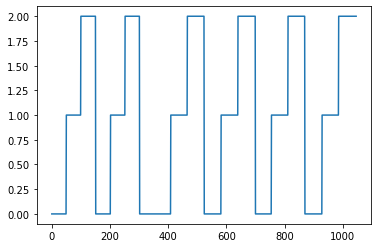

In [ ]:
def plot_subjects():
    uniques, s_num = np.unique(sub, return_inverse=True)
    print (uniques)
    plt.plot(s_num) 
    plt.show()
#plot_subjects()